In [1]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
'''
GPU 사용 선언
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [4]:
'''
하이퍼파라미터 선언
'''
sequence_length = 6
input_size = 2
hidden_size = 16
output_size = 1
num_layers = 2
learning_rate = 1e-3
nb_epochs = 300

In [5]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Champagne_Sales.csv')
print(original_data_df.shape)
print(original_data_df)

(105, 2)
       Month  Champagne sales
0    1964-01             2815
1    1964-02             2672
2    1964-03             2755
3    1964-04             2721
4    1964-05             2946
..       ...              ...
100  1972-05             4618
101  1972-06             5312
102  1972-07             4298
103  1972-08             1413
104  1972-09             5877

[105 rows x 2 columns]


In [6]:
'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sales']
print(original_data_df.head())

     Month  Sales
0  1964-01   2815
1  1964-02   2672
2  1964-03   2755
3  1964-04   2721
4  1964-05   2946


In [7]:
'''
날짜 하이픈 제거
'''
original_data_df['Month'] = original_data_df['Month'].str.replace(pat=r'[^\w\s]', repl=r'', regex=True) # 하이픈제거
original_data_df = original_data_df.astype('int')

In [8]:
'''
train, test data 분리
'''
train_size = int(len(original_data_df) * 0.7)
train_set = original_data_df[0:train_size]
test_set = original_data_df[train_size - sequence_length:]

In [9]:
'''
스케일링함수 선언
'''
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

'''
데이터셋 함수 선언
'''
def build_data(time_series, sequence_length):
    x_data = []
    y_data = []

    for i in range(0, len(time_series) - sequence_length):
        _x = time_series.values[i: i + sequence_length, :]
        _y = time_series.values[i + sequence_length, [-1]]
        x_data.append(_x)
        y_data.append(_y)

    return np.array(x_data), np.array(y_data)

'''
데이터로더 함수 선언
'''
def MakeDataLoader(x_np, y_np):
    '''
    totensor
    '''
    x_ts = torch.FloatTensor(x_np)
    y_ts = torch.FloatTensor(y_np)

    '''
    dataset & dataloader
    '''
    dataset = TensorDataset(x_ts, y_ts)
    dataloader = DataLoader(dataset, batch_size = sequence_length, shuffle = True)

    return dataloader

In [10]:
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

x_train_np, y_train_np = build_data(train_set, sequence_length)
x_test_np, y_test_np = build_data(test_set, sequence_length)

train_dataloader = MakeDataLoader(x_train_np, y_train_np)
test_dataloader = MakeDataLoader(x_test_np, y_test_np)

In [11]:
'''
모델 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [12]:
'''
모델, 비용함수, 옵티마이저 정의
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
'''
학습
'''
for epoch in range(nb_epochs):
    train_loss = 0.0
    for i, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(x_train)
        loss = criterion(hypothesis, y_train)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print("Epoch: {} | Loss: {:.6f}".format(epoch, loss.item()))

Epoch: 0 | Loss: 0.726251
Epoch: 1 | Loss: 0.000109
Epoch: 2 | Loss: 0.000435
Epoch: 3 | Loss: 0.000330
Epoch: 4 | Loss: 0.014238
Epoch: 5 | Loss: 0.026972
Epoch: 6 | Loss: 0.007828
Epoch: 7 | Loss: 0.011024
Epoch: 8 | Loss: 0.022527
Epoch: 9 | Loss: 0.038333
Epoch: 10 | Loss: 0.046660
Epoch: 11 | Loss: 0.018860
Epoch: 12 | Loss: 0.006956
Epoch: 13 | Loss: 0.001190
Epoch: 14 | Loss: 0.022784
Epoch: 15 | Loss: 0.014278
Epoch: 16 | Loss: 0.077753
Epoch: 17 | Loss: 0.001327
Epoch: 18 | Loss: 0.145669
Epoch: 19 | Loss: 0.010664
Epoch: 20 | Loss: 0.010021
Epoch: 21 | Loss: 0.012197
Epoch: 22 | Loss: 0.004261
Epoch: 23 | Loss: 0.112069
Epoch: 24 | Loss: 0.002081
Epoch: 25 | Loss: 0.015482
Epoch: 26 | Loss: 0.240873
Epoch: 27 | Loss: 0.012685
Epoch: 28 | Loss: 0.038746
Epoch: 29 | Loss: 0.006678
Epoch: 30 | Loss: 0.086814
Epoch: 31 | Loss: 0.050474
Epoch: 32 | Loss: 0.010816
Epoch: 33 | Loss: 0.007922
Epoch: 34 | Loss: 0.011234
Epoch: 35 | Loss: 0.049417
Epoch: 36 | Loss: 0.160155
Epoch: 37 |

In [14]:
'''
모델 저장
'''
torch.save(model, './data/model.pt')

In [15]:
'''
평가
'''
with torch.no_grad():
    predicted_data_list = []
    label_list = []
    for i, samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        prediction = model(x_test)
        predicted_data_list.append(prediction.tolist())
        label_list.append(y_test.tolist())#.cpu().data.numpy())
        loss = criterion(prediction, y_test)

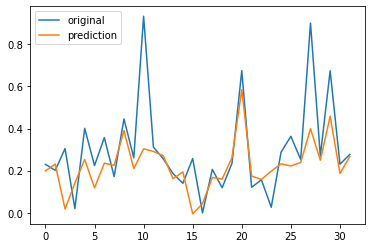

In [16]:
'''
시각화
'''
predicted_data_np = np.array(sum(sum(predicted_data_list, []), []))
label_np = np.array(sum(sum(label_list, []), []))

#%matplotlib inline
plt.plot(label_np)
plt.plot(predicted_data_np)
plt.legend(['original', 'prediction'])
plt.show()